### <i> Note: Please change the acclerator to GPU to train faster at the beginning. </i>

# *Section 1: The Provided Baseline Detection of Helmets*

## 1.1 Importing Required Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import subprocess
from IPython.display import Video, display

import matplotlib.pylab as plt

print('Cell Executed')

## 1.2 Loading and Setting the Dataset

In [2]:
# Read in data files
BASE_DIR = '../input/nfl-health-and-safety-helmet-assignment'

# Labels and sample submission
labels = pd.read_csv(f'{BASE_DIR}/train_labels.csv')

# Baseline helmet detection labels
tr_helmets = pd.read_csv(f'{BASE_DIR}/train_baseline_helmets.csv')
te_helmets = pd.read_csv(f'{BASE_DIR}/test_baseline_helmets.csv')

print('Cell Executed')

## 1.3 Baselines Boxes with an example video
The provided baseline boxes are imperfect but allow us to quickly tackle the problem without having to address the helmet detection. The below video shows an example of these baseline predictions alongside the true helmet labels.

In [3]:
def video_with_baseline_boxes(
    video_path: str, baseline_boxes: pd.DataFrame, gt_labels: pd.DataFrame, verbose=True
) -> str:
    """
    Annotates a video with both the baseline model boxes and ground truth boxes.
    Baseline model prediction confidence is also displayed.
    """
    VIDEO_CODEC = "MP4V"
    HELMET_COLOR = (0, 0, 0)  # Black
    BASELINE_COLOR = (255, 255, 255)  # White
    IMPACT_COLOR = (0, 0, 255)  # Red
    video_name = os.path.basename(video_path).replace(".mp4", "")
    if verbose:
        print(f"Running for {video_name}")
    baseline_boxes = baseline_boxes.copy()
    gt_labels = gt_labels.copy()

    baseline_boxes["video"] = (
        baseline_boxes["video_frame"].str.split("_").str[:3].str.join("_")
    )
    gt_labels["video"] = gt_labels["video_frame"].str.split("_").str[:3].str.join("_")
    baseline_boxes["frame"] = (
        baseline_boxes["video_frame"].str.split("_").str[-1].astype("int")
    )
    gt_labels["frame"] = gt_labels["video_frame"].str.split("_").str[-1].astype("int")

    vidcap = cv2.VideoCapture(video_path)
    fps = vidcap.get(cv2.CAP_PROP_FPS)
    width = int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    output_path = "labeled_" + video_name + ".mp4"
    tmp_output_path = "tmp_" + output_path
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
    output_video = cv2.VideoWriter(tmp_output_path, fourcc, fps, (width, height))
    frame = 0
    while True:
        it_worked, img = vidcap.read()
        if not it_worked:
            break
        # We need to add 1 to the frame count to match the label frame index
        # that starts at 1
        frame += 1

        # Let's add a frame index to the video so we can track where we are
        img_name = f"{video_name}_frame{frame}"
        cv2.putText(
            img,
            img_name,
            (0, 50),
            cv2.FONT_HERSHEY_SIMPLEX,
            1.0,
            HELMET_COLOR,
            thickness=2,
        )

        # Now, add the boxes
        boxes = baseline_boxes.query("video == @video_name and frame == @frame")
        if len(boxes) == 0:
            print("Boxes incorrect")
            return
        for box in boxes.itertuples(index=False):
            cv2.rectangle(
                img,
                (box.left, box.top),
                (box.left + box.width, box.top + box.height),
                BASELINE_COLOR,
                thickness=1,
            )
            cv2.putText(
                img,
                f"{box.conf:0.2}",
                (box.left, max(0, box.top - 5)),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                BASELINE_COLOR,
                thickness=1,
            )

        boxes = gt_labels.query("video == @video_name and frame == @frame")
        if len(boxes) == 0:
            print("Boxes incorrect")
            return
        for box in boxes.itertuples(index=False):
            # Filter for definitive head impacts and turn labels red
            if box.isDefinitiveImpact == True:
                color, thickness = IMPACT_COLOR, 3
            else:
                color, thickness = HELMET_COLOR, 1
            cv2.rectangle(
                img,
                (box.left, box.top),
                (box.left + box.width, box.top + box.height),
                color,
                thickness=thickness,
            )
            cv2.putText(
                img,
                box.label,
                (box.left + 1, max(0, box.top - 20)),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                color,
                thickness=1,
            )

        output_video.write(img)
    output_video.release()
    # Not all browsers support the codec, we will re-load the file at tmp_output_path
    # and convert to a codec that is more broadly readable using ffmpeg
    if os.path.exists(output_path):
        os.remove(output_path)
    subprocess.run(
        [
            "ffmpeg",
            "-i",
            tmp_output_path,
            "-crf",
            "18",
            "-preset",
            "veryfast",
            "-vcodec",
            "libx264",
            output_path,
        ]
    )
    os.remove(tmp_output_path)

    return output_path


### 1.4 We played the test video named with the boxes: "57906_000718_Endzone.mp4"

In [4]:
example_video = '../input/nfl-health-and-safety-helmet-assignment/test/57906_000718_Endzone.mp4'
output_video = video_with_baseline_boxes(example_video,
                          tr_helmets, labels)

frac = 0.65 # scaling factor for display
display(Video(data=output_video,
              embed=True,
              height=int(720*frac),
              width=int(1280*frac))
       )

# **2. Implementing YOLOv5 object detection algorithm for the helmet detection.**

### Setup

The structure that requires YOLOv5 to run

```
/parent_folder
    /dataset
         /images
         /labels
    /yolov5
```

In [5]:
# making a directory in ../ path
%cd ../
!mkdir CS460G
%cd CS460G

In [6]:
# download YOLOv5 from github repos
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5


# Install dependencies
%pip install -qr requirements.txt  # install dependencies
%pip install -r requirements.txt wandb  # install

# Changing the directory
%cd ../
import torch
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

# How to login to Weight & Biases section? 
To login, please run the below cell and it will ask you to go to a website called https://wandb.ai/authorize and you will get the API key to look at the metric and performance. You need to go the project name to look at the parameters. The output should look like this.  
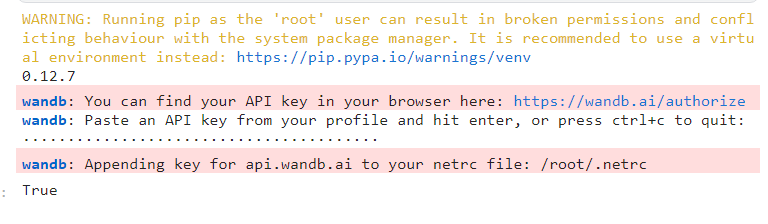

In [7]:
# Install W&B 
!pip install -q --upgrade wandb


# Login 
import wandb
print(wandb.__version__)
wandb.login()

In [8]:
#Importing required libraries
import os # for miscelleneous operating system libraries
import gc # for the garbage collector
import cv2 #for OpenCV Computer vision applications
import numpy as np #for mathematical operation on arrays
import pandas as pd #for data exploration and analysis
from tqdm import tqdm # for the smart progress bar output
from shutil import copyfile # for copying conent of source file to the destination file
import matplotlib.pyplot as plt #for plots like in MATLAB
from sklearn.model_selection import train_test_split #for splitting the data into training and testing
from IPython.core.display import Video, display #for displaying the video in the notebook
import subprocess #for creating new processes and running them
print('Done')

## Setting up the Hyperparamters
We made different changes in the hyperparamters and showed the performance as well in the report. 

In [9]:
#Changing directory to its root folder
%cd ../

TRAIN_PATH = 'input/nfl-health-and-safety-helmet-assignment/images/'
BATCH_SIZE = 16 # hyperparameter
# We have put number of epochs as 1 because it will hours to complete the training if we increase it to train. 
EPOCHS = 10 # hyperparamete

print(f'Number of extra images: {len(os.listdir(TRAIN_PATH))}') 

In [10]:
# Load image level csv file
extra_df = pd.read_csv('input/nfl-health-and-safety-helmet-assignment/image_labels.csv')
print('Number of ground truth bounding boxes: ', len(extra_df))

# Number of unique labels
label_to_id = {label: i for i, label in enumerate(extra_df.label.unique())}
print('Unique labels: ', label_to_id)

# Group together bbox coordinates belonging to the same image. 
# key is the name of the image, value is a dataframe with label and bbox coordinates. 
image_bbox_label = {} 
for image, df in extra_df.groupby('image'): 
    image_bbox_label[image] = df.reset_index(drop=True)

# Visualize
extra_df.head()

### Now, we will split the images into training and testing images with the test size of 20 percent of all dataset i.e. 9947*0.2 = 7957 and rest as training dataset

In [11]:
# train/validation split.
train_names, valid_names = train_test_split(list(image_bbox_label), test_size=0.2, random_state=42)
print(f'Size of dataset: {len(image_bbox_label)},\
       training images: {len(train_names)},\
       validation images: {len(valid_names)}')

The required folder structure for the dataset directory is:

```
/parent_folder
    /dataset
         /images
             /train
             /valid
         /labels
             /train
             /valid
    /yolov5
```

### Making the directories as above

In [12]:
os.makedirs('CS460G/nfl_extra/images/train', exist_ok=True)
os.makedirs('CS460G/nfl_extra/images/valid', exist_ok=True)

os.makedirs('CS460G/nfl_extra/labels/train', exist_ok=True)
os.makedirs('CS460G/nfl_extra/labels/valid', exist_ok=True)

# Moving the images to relevant split folder.
for img_name in tqdm(train_names):
    copyfile(f'{TRAIN_PATH}/{img_name}', f'CS460G/nfl_extra/images/train/{img_name}')

for img_name in tqdm(valid_names):
    copyfile(f'{TRAIN_PATH}/{img_name}', f'CS460G/nfl_extra/images/valid/{img_name}')

In [13]:
import yaml
# create dictionary for data
data_yaml = dict(
    train = '../nfl_extra/images/train',
    val = '../nfl_extra/images/valid',
    nc = 5, # number of classess
    names = list(extra_df.label.unique())  # names of classes
)

# *Note*: the file is created in the yolov5/data/ directory.
with open('CS460G/yolov5/data/data.yaml', 'w') as outfile:
    yaml.dump(data_yaml, outfile, default_flow_style=True)
    
%cat CS460G/yolov5/data/data.yaml

In [14]:
data_yaml['names']

In [15]:
def get_yolo_format_bbox(img_w, img_h, box):
    """
    Convert the bounding boxes to YOLO format.
    
    Input:
    img_w - Original/Scaled image width
    img_h - Original/Scaled image height
    box - Bounding box coordinates in the format, "left, width, top, height"
    
    Output:
    Return YOLO formatted bounding box coordinates, "x_center y_center width height".
    """
    w = box.width # width 
    h = box.height # height
    xc = box.left + int(np.round(w/2)) # xmin + width/2
    yc = box.top + int(np.round(h/2)) # ymin + height/2

    return [xc/img_w, yc/img_h, w/img_w, h/img_h] # x_center y_center width height
    
# Iterate over each image and write the labels and bbox coordinates to a .txt file. 
for img_name, df in tqdm(image_bbox_label.items()):
    # open image file to get the height and width 
    img = cv2.imread(TRAIN_PATH+'/'+img_name)
    height, width, _ = img.shape 
    
    # iterate over bounding box df
    bboxes = []
    for i in range(len(df)):
        # get a row
        box = df.loc[i]
        # get bbox in YOLO format
        box = get_yolo_format_bbox(width, height, box)
        bboxes.append(box)
    
    if img_name in train_names:
        img_name = img_name[:-4]
        file_name = f'CS460G/nfl_extra/labels/train/{img_name}.txt'
    elif img_name in valid_names:
        img_name = img_name[:-4]
        file_name = f'CS460G/nfl_extra/labels/valid/{img_name}.txt'
        
    with open(file_name, 'w') as f:
        for i, bbox in enumerate(bboxes):
            label = label_to_id[df.loc[i].label]
            bbox = [label]+bbox
            bbox = [str(i) for i in bbox]
            bbox = ' '.join(bbox)
            f.write(bbox)
            f.write('\n')

In [16]:
%pwd

In [17]:
#Changing the directory to yolov5 to train
%cd CS460G/yolov5/



In [18]:
# For Weights & Biases  visualization
# turn off W&B syncing if you don't need

#os.environ['WANDB_MODE'] = 'offline'
# Uncomment this section to use the wandb
%pip install -q wandb
import wandb
wandb.login()

In [19]:
#Training the yolov5
!python train.py --img 720 \
                 --batch {BATCH_SIZE} \
                 --epochs {EPOCHS} \
                 --data data.yaml \
                 --weights yolov5s.pt \
                 --save-period 1\
                 --project nfl-extra

### Playing an example video before training on the images

In [20]:
#Experimenting the detection in a video from the NFL video
data_dir = '/kaggle/input/nfl-health-and-safety-helmet-assignment/'
example_video = f'{data_dir}/test/57906_000718_Endzone.mp4'

#video example
frac = 0.65 #selecting only a part of the frame from a video
display(Video(example_video, embed=True, height=int(720*frac), width=int(1280*frac)))

In [21]:
# create frames from video
img_ext = 'png'
image_name = '57906_000718_Endzone'
frame_dir = '/kaggle/CS460G/mp4_img/'
os.makedirs(frame_dir, exist_ok=True)

cmd = 'ffmpeg -i \"{}\" -qscale:v 2 \"{}/{}_%d.{}\"'.format(example_video, frame_dir, image_name, img_ext)
print(cmd)
subprocess.call(cmd, shell=True)

In [22]:
# output folder name
project_name = '57906_000718_Endzone'
# best weights after training
best_weights = 'nfl-extra/exp/weights/best.pt'

### Training with the yolov5 algorithm

In [23]:
!python detect.py --weights {best_weights} \
                  --source {frame_dir} \
                  --img 720 \
                  --save-txt \
                  --save-conf \
                  --project {project_name}

In [24]:
os.listdir()

### Playing the video named: '57906_000718_Endzone_fps60.mp4' after Yolov5 training

In [25]:
# make video from frames
video_name = '57906_000718_Endzone_fps60.mp4'
tmp_video_path = os.path.join('/kaggle/working/', f'CS460G_{video_name}')
video_path = os.path.join('/kaggle/working/', video_name)

frame_rate = 60

images = [img for img in os.listdir(f'{project_name}/exp')]
images.remove('labels')
images.sort(key = lambda x: int(x.split('_')[-1][:-4]))

frame = cv2.imread(os.path.join('57906_000718_Endzone/exp', images[0]))
height, width, layers = frame.shape

fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
video = cv2.VideoWriter(tmp_video_path, fourcc,
                        frame_rate, (width,height))

for f in images:
    img = cv2.imread(os.path.join('57906_000718_Endzone/exp', f))
    video.write(img)

video.release()

# Not all browsers support the codec, we will re-load the file at tmp_video_path
# and convert to a codec that is more broadly readable using ffmpeg

if os.path.exists(video_path):
    os.remove(video_path)
    
subprocess.run(["ffmpeg", "-i", tmp_video_path, "-crf", "18", "-preset", "veryfast",
                "-vcodec","libx264", video_path,])

os.remove(tmp_video_path)

In [26]:
frac = 0.65
display(Video(video_path, embed=True, height=int(720*frac), width=int(1280*frac)))